### 1.Kütüphanelerin Import Edilmesi

In [ ]:
import torch
from torch import nn
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
import torchvision

### 2.Verinin Çekilmesi ve Dönüşümünün Yapılması

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"You are using {device}")

You are using cuda


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227,227)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [6]:
train_data = torchvision.datasets.CIFAR10(
    root = "./data",
    train = True,
    download = True,
    transform = transform
)

test_data = torchvision.datasets.CIFAR10(
    root = "./data",
    train = False,
    download = True,
    transform = transform
)

100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 3.Verinin İncelenmesi

In [7]:
train_data, test_data

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ))

In [8]:
print(train_data.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [15]:
import random 
rand_num = random.randint(0, len(train_data))
train_img, train_label = train_data[rand_num]
train_img.shape, train_label

(torch.Size([3, 224, 224]), 0)

Text(0.5, 1.0, 'airplane')

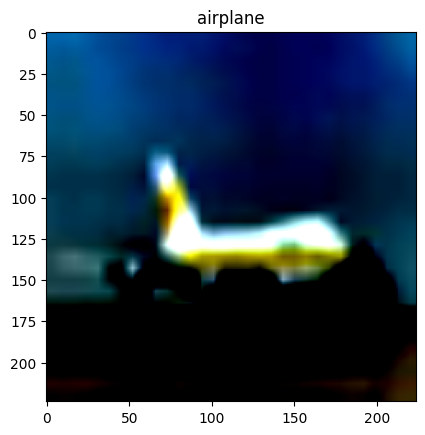

In [26]:
import matplotlib.pyplot as plt
plt.imshow(torch.permute(train_img, (1,2,0)))
plt.title(train_data.classes[train_label])

### 4.Model Mimarisinin Oluşturulması
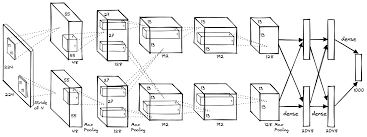

In [ ]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        #96x55x55
        self.conv1 = nn.Conv2d(in_channels = 3, kernel_size = (11,11), out_channels = 96,
                              stride = 4, padding = 0)
        #96x27x27
        self.maxpool1 = nn.MaxPool2d((3,3), stride = 2)
        #256x27x27
        self.conv2 = nn.Conv2d(in_channels = 96, kernel_size = (5,5), out_channels = 256,
                              stride = 1, padding = 2)
        #256x13x13
        self.maxpool2 = nn.MaxPool2d((3,3), stride = 2)
        #384x13x13
        self.conv4 = nn.Conv2d(in_channels = 256, kernel_size = (3,3), out_channels = 384,
                              stride = 1, padding = 1) 
        #384x13x13
        self.conv5 = nn.Conv2d(in_channels = 384, kernel_size = (3,3), out_channels = 384,
                              stride = 1, padding = 1) 
        #256x13x13
        self.conv6 = nn.Conv2d(in_channels = 384, kernel_size = (3,3), out_channels = 256,
                              stride = 1, padding = 1)
        #256x6x6
        self.maxpool3 = nn.MaxPool2d((3,3), stride = 2)
        self.fc1 = nn.Linear(6*6*256, 9216)
        self.fc2 = nn.Linear(9216, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x) -> torch.Tensor:
        x = self.maxpool1(self.conv1(x))
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv6(self.conv5(self.conv4(x)))
        x = self.maxpool3(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [10]:
model = AlexNet().to(device)
model

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=9216, bias=True)
  (fc2): Linear(in_features=9216, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)

In [11]:
rand_tens = torch.randn(1, 3, 227, 227).to(device)
model(rand_tens)

tensor([[-0.0043,  0.0150,  0.0080,  0.0010,  0.0022, -0.0122,  0.0073, -0.0337,
          0.0383,  0.0303]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 5.DataLoader'ların Oluşturulması

In [12]:
#Verilerin model eğitimi için dataloader haline getirilmesi
train_dataloader = DataLoader(
    train_data,
    shuffle = True,
    batch_size = 16
)

test_dataloader = DataLoader(
    test_data,
    shuffle = False,
    batch_size = 16
)

In [13]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78dccc6b3880>,
 <torch.utils.data.dataloader.DataLoader at 0x78dccc847040>)

### 6.Model Eğitimi
Normalde optimizer olarak Gradient Descent seçilip batch_size = 128, momentum =0.9 ve weight_decay=0.0005 olacak şekilde eğitilmiştir. 

In [27]:
#Model eğitimi
optim = torch.optim.Adam(model.parameters(), lr = 10e-4)
loss = nn.CrossEntropyLoss()

def train(model, trainloader, optimizer, loss_fn, epochs=10):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        for index, (X, y) in enumerate(trainloader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(trainloader) 
        train_losses.append(avg_loss)
        print(f"Epoch : [{epoch+1} / {epochs}] Loss: {avg_loss:.4f}")
    return train_losses

In [32]:
def test(model, testloader, loss_fn):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for index, (X,y) in enumerate(testloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss += loss.item()
    avg_loss = test_loss / len(testloader)
    print(f"Test Loss : {avg_loss:.4f}")
    return avg_loss

In [ ]:
train_losses = train(model, train_dataloader, optim, loss)
train_losses

In [ ]:
test_losses = test(model, test_dataloader, loss)
test_losses